<a href="https://colab.research.google.com/github/Carlos6464/Carlos6464/blob/main/dog_vs_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import zipfile
import os
from google.colab import files


In [20]:
# URL do arquivo zip
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Baixar o arquivo usando wget
!wget {url} -O kagglecatsanddogs_5340.zip

# Descompactar o arquivo ZIP
with zipfile.ZipFile('kagglecatsanddogs_5340.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Verificar se os arquivos foram extraídos corretamente
os.listdir('data')

# Caminhos para os diretórios de treino e validação
train_dir = 'data/PetImages/Cat'
validation_dir = 'data/PetImages/Dog'



--2025-01-24 03:52:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.197.18.22, 2600:1407:7800:295::317f, 2600:1407:7800:2ab::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.197.18.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  30.8MB/s    in 13s     

2025-01-24 03:52:39 (62.0 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [21]:
# Criar geradores de dados de treino e validação usando ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Carregar imagens a partir dos diretórios e gerar lotes de imagens
train_generator = train_datagen.flow_from_directory(
    'data/PetImages',
    target_size=(150, 150),  # Redimensionar as imagens
    batch_size=32,
    class_mode='binary'  # Classificação binária (Cachorro vs Gato)
)

validation_generator = validation_datagen.flow_from_directory(
    'data/PetImages',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 25000 images belonging to 2 classes.
Found 25000 images belonging to 2 classes.


In [ ]:
# Carregar o modelo VGG16 pré-treinado sem as camadas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar as camadas do modelo base
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Construir o modelo completo
model = models.Sequential([
    base_model,  # Certifique-se de que base_model já foi definido
    layers.Flatten(),
    layers.Dropout(0.4),  # Ajuste de dropout
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),  # Adicionando mais dropout para evitar overfitting
    layers.Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Defina a taxa de aprendizado que você deseja
learning_rate = 0.0001  # Ajuste conforme necessário

# Crie o otimizador com a taxa de aprendizado ajustada
optimizer = Adam(learning_rate=learning_rate)

# Compile o modelo com o novo otimizador
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


In [ ]:
# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Reduzido para 10 lotes por época
    epochs=10,  # Mantido 3 épocas para teste
    validation_data=validation_generator,
    validation_steps=10  # Reduzido para 10 lotes para validação
)

# Visualizar as métricas armazenadas no objeto 'history'
print(history.history.keys())
# Saída esperada: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Acurácia por época
print("Acurácia por época no treinamento:", history.history['accuracy'])
print("Acurácia por época na validação:", history.history['val_accuracy'])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 212s 22s/step - accuracy: 0.5113 - loss: 0.9056 - val_accuracy: 0.7031 - val_loss: 0.5873
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 217s 23s/step - accuracy: 0.5903 - loss: 0.7111 - val_accuracy: 0.8125 - val_loss: 0.4831
Epoch 3/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:29 10s/step - accuracy: 0.5938 - loss: 0.7654

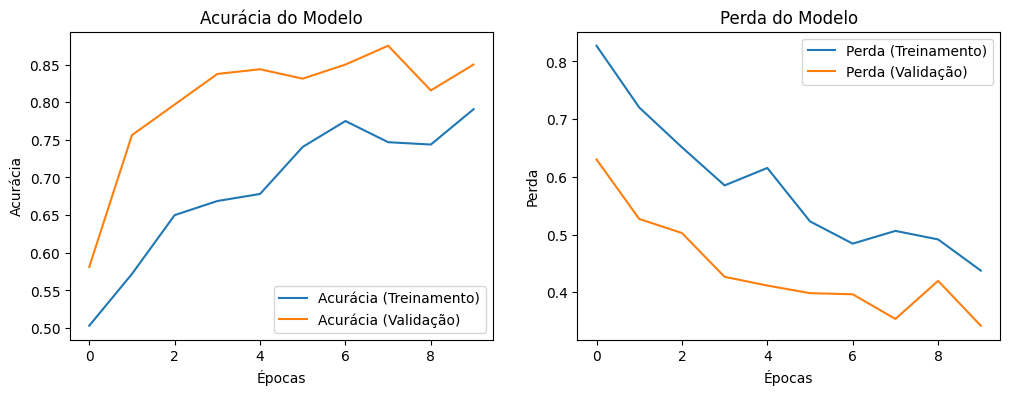

In [ ]:
def plot_history(history):
    # Plotar a acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia (Treinamento)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotar a perda (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda (Treinamento)')
    plt.plot(history.history['val_loss'], label='Perda (Validação)')
    plt.title('Perda do Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Plotar os gráficos de acurácia e perda
plot_history(history)


In [ ]:
# Definir o número de lotes a serem processados
steps = 100  # Número de lotes desejado

# Fazer previsões limitando os lotes
valid_preds = model.predict(validation_generator, steps=steps)

# Converter as previsões para uma forma binária (0 ou 1)
valid_preds = (valid_preds > 0.5).astype(int)

# Obter os rótulos reais das imagens de validação para as imagens limitadas
valid_labels = validation_generator.classes[:steps * validation_generator.batch_size]

# Calcular a matriz de confusão
cm = confusion_matrix(valid_labels, valid_preds)
print("Matriz de Confusão:")
print(cm)




100/100 ━━━━━━━━━━━━━━━━━━━━ 764s 8s/step
Matriz de Confusão:
[[1442 1758]
 [   0    0]]
